In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StringType
import header as hdr

import seaborn as sns

spark = SparkSession.builder.master("local[*]")\
        .appName("SparkByExamples.com")\
        .getOrCreate()

21/11/23 09:00:01 WARN Utils: Your hostname, pasokon resolves to a loopback address: 127.0.1.1; using 192.168.1.96 instead (on interface wlo1)
21/11/23 09:00:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/11/23 09:00:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
def get_dataframe(table_name):
    header = hdr.get_table_header(table_name)
    schema = StructType()

    for h in header:
        schema.add(h, StringType(), True)

    return spark.read.option('delimiter', ',').format("csv")\
            .schema(schema).load(f"data/{table_name}.csv").fillna('NA')

In [3]:
df = get_dataframe('machine_events')
df.printSchema()

root
 |-- time: string (nullable = false)
 |-- machine_id: string (nullable = false)
 |-- event_type: string (nullable = false)
 |-- platform_id: string (nullable = false)
 |-- cpus: string (nullable = false)
 |-- memory: string (nullable = false)



In [4]:
df.groupBy('cpus').count().show()

+----+-----+
|cpus|count|
+----+-----+
|0.25|  510|
|  NA|   32|
| 0.5|35015|
|   1| 2223|
+----+-----+



In [5]:
task_events = get_dataframe('task_events')
task_events.printSchema()

root
 |-- time: string (nullable = false)
 |-- missing_info: string (nullable = false)
 |-- job_id: string (nullable = false)
 |-- task_index: string (nullable = false)
 |-- machine_id: string (nullable = false)
 |-- event_type: string (nullable = false)
 |-- user: string (nullable = false)
 |-- scheduling_class: string (nullable = false)
 |-- priority: string (nullable = false)
 |-- cpu_request: string (nullable = false)
 |-- memory_request: string (nullable = false)
 |-- disk_space_request: string (nullable = false)
 |-- different_machines_restriction: string (nullable = false)



In [6]:
import pyspark.sql.functions as F

task_per_event = task_events.groupBy('job_id').count()
task_per_event.select(
    F.round(F.mean('count'),2).alias('mean'), F.round(F.stddev('count'), 2).alias('std'),
    F.min('count').alias('min'), F.max('count').alias('max')
).show()

+-----+------+---+-----+
| mean|   std|min|  max|
+-----+------+---+-----+
|91.96|844.02|  1|46037|
+-----+------+---+-----+



In [7]:
task_events.select(F.countDistinct(task_events.job_id)).show()

+----------------------+
|count(DISTINCT job_id)|
+----------------------+
|                  4895|
+----------------------+



## What is the distribution of the number jobs/tasks per scheduling class?

In [8]:
jts = task_events.select(
    task_events.scheduling_class, task_events.job_id, task_events.task_index
)
#jts.printSchema()
jts.groupBy('scheduling_class').agg(F.countDistinct(jts.job_id), F.count(jts.task_index)).orderBy(jts.scheduling_class).show()

+----------------+-------------+-----------------+
|scheduling_class|count(job_id)|count(task_index)|
+----------------+-------------+-----------------+
|               0|          919|           237969|
|               1|         1624|            58109|
|               2|         1419|            97482|
|               3|          933|            56586|
+----------------+-------------+-----------------+



### Do tasks with low priority have a higher probability of being evicted?

P(Evicted|Priority) = P(Evicted n Priority)/P(Priority)

In [41]:
prievic = task_events.select(task_events.priority.cast('int'), task_events.event_type.cast('int'))

In [27]:
def prob_evic_priority(priority):
    return (
        prievic.select(prievic['*']).where((prievic.event_type == 2) & (prievic.priority == priority)).count() /
        float(prievic.select(prievic['*']).where(prievic.priority == priority).count())
    )

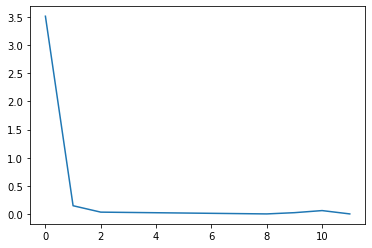

In [42]:
priorities = sorted([x[0] for x in prievic.select(prievic.priority).distinct().collect()])
probs = [prob_evic_priority(p) for p in priorities]
sns.lineplot(x=priorities, y=[x*100 for x in probs]);